In [3]:
import os
import librosa as lb
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import shutil
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import pickle

In [4]:
Scaler = MinMaxScaler(feature_range=(0,1))

In [5]:
duration = []
for i in os.listdir('Uji'):
    folder = os.path.join('Uji',i)
    for j in os.listdir(folder):
        filename = os.path.join(folder,j)
        wav,sr = lb.load(filename,sr=None)
        len_duration = lb.get_duration(wav,sr=sr)
        duration.append(len_duration)

print (max(duration))

2.976


In [41]:
train = []
for i in os.listdir('Uji'):
    folder = os.path.join('Uji',i)
    for j in os.listdir(folder):
        filename = os.path.join(folder,j)
        wav,sr = lb.load(filename,sr=None)
        pad = lb.util.pad_center(wav,sr*3)
        rms = lb.feature.rms(y=pad)
        rms = rms.reshape(rms.shape[1],rms.shape[0])
        rms_norm = Scaler.fit_transform(rms)
        #rms_norm = rms.reshape(1,rms.shape[0])

        train.append(rms_norm)
            
train = np.array(train)
train = train.reshape(train.shape[0],train.shape[1])

In [47]:
test = []
label = []

category = {'neg':0,'pos':1}

for folder in os.listdir('audio_test'):
    if folder == 'neg':
        paths = os.path.join('audio_test',folder)
        for file in os.listdir(paths):
            filename = os.path.join(paths,file)
            #print(filename)
            wav,sr = lb.load(filename,sr=None)
            dur = lb.get_duration(wav,sr)
            pad = lb.util.pad_center(wav,sr*3)
            rms = lb.feature.rms(y=pad)
            rms = rms.reshape(rms.shape[1],rms.shape[0])
            rms_norm = Scaler.fit_transform(rms)
            rms_norm = rms.reshape(1,rms.shape[0])

            pred = gm.predict(rms_norm)
            if pred == 1:
                print(filename,pred,dur)

            #test.append(rms_norm)
            #label.append(category[folder])
        
#test = np.array(test)
#test = test.reshape(test.shape[0],test.shape[1])
#label = to_categorical(label)

audio_test\neg\devel_004-3.wav [1] 0.48
audio_test\neg\devel_004-7.wav [1] 0.256
audio_test\neg\devel_008-1.wav [1] 0.288
audio_test\neg\devel_008-4.wav [1] 0.224
audio_test\neg\devel_008-5.wav [1] 0.288
audio_test\neg\devel_010-2.wav [1] 0.32
audio_test\neg\devel_015-0.wav [1] 0.192
audio_test\neg\devel_016-0.wav [1] 0.0
audio_test\neg\devel_017-2.wav [1] 0.288
audio_test\neg\test_006-4.wav [1] 0.352
audio_test\neg\test_007-1.wav [1] 0.288
audio_test\neg\test_008-2.wav [1] 0.224
audio_test\neg\test_011-2.wav [1] 0.288
audio_test\neg\test_013-0.wav [1] 0.288
audio_test\neg\test_013-1.wav [1] 0.288
audio_test\neg\test_013-3.wav [1] 0.288
audio_test\neg\test_018-0.wav [1] 0.416
audio_test\neg\test_029-2.wav [1] 0.224
audio_test\neg\train_001-0.wav [1] 0.224
audio_test\neg\train_001-1.wav [1] 0.32
audio_test\neg\train_006-0.wav [1] 0.352
audio_test\neg\train_006-2.wav [1] 0.32
audio_test\neg\train_013-0.wav [1] 0.288
audio_test\neg\train_017-1.wav [1] 0.352
audio_test\neg\train_019-0.wav 

In [48]:
test = []
label = []

category = {'other':1,'cough':2,'repeat':0}

for folder in os.listdir('testing'):
    #if folder == 'neg':
    paths = os.path.join('testing',folder)
    for file in os.listdir(paths):
        filename = os.path.join(paths,file)
        #print(filename)
        wav,sr = lb.load(filename,sr=None)
        pad = lb.util.pad_center(wav,sr*3)
        rms = lb.feature.rms(y=pad)
        rms = rms.reshape(rms.shape[1],rms.shape[0])
        rms_norm = Scaler.fit_transform(rms)
        #rms_norm = rms.reshape(1,rms.shape[0])

        #pred = gm.predict(rms_norm)
        #if pred == 1:
            #print(filename,pred)

        test.append(rms_norm)
        label.append(category[folder])

test = np.array(test)
test = test.reshape(test.shape[0],test.shape[1])
label = to_categorical(label)

In [42]:
gm = GaussianMixture(n_components=3, random_state=42).fit(train)

In [43]:
filename = 'model_gm.sav'

In [44]:
pickle.dump(gm, open(filename, 'wb'))

In [45]:
gm = pickle.load(open(filename, 'rb'))

UAR:  0.8222222222222223
Accuracy:  0.9157894736842105
Cohen Kappa Score:  0.8591839255568823
              precision    recall  f1-score   support

      repeat       1.00      0.47      0.64        45
       other       1.00      1.00      1.00       119
       cough       0.83      1.00      0.91       121

    accuracy                           0.92       285
   macro avg       0.94      0.82      0.85       285
weighted avg       0.93      0.92      0.90       285



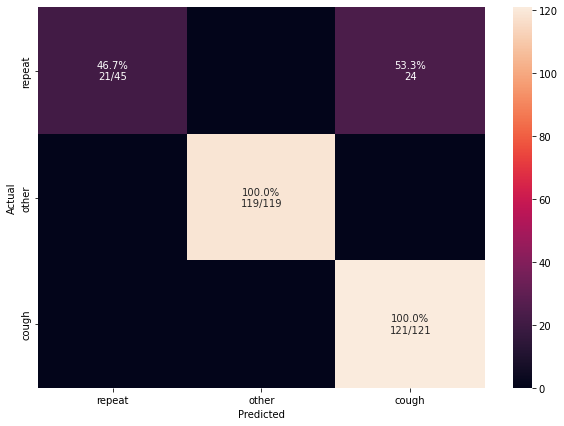

In [50]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score, cohen_kappa_score
matrix_index = ['repeat', 'other','cough']

classpreds = gm.predict(test)
#classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(label, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)

UAR = balanced_accuracy_score(y_testclass, classpreds)
accuracy = accuracy_score(y_testclass,classpreds)
#roc_auc = roc_auc_score(y_testclass,classpreds,average ='macro')
kappa = cohen_kappa_score(classpreds,y_testclass)

print('UAR: ', UAR)
print('Accuracy: ', accuracy)
#print('ROC AUC Score: ', roc_auc)
print('Cohen Kappa Score: ', kappa)
print('='*40)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')
plt.savefig("Confusion_Matrix.jpg")